# 3. Analysis

This part is an analysis of the data that is produced by the simulation notebook. We should be able to generate a model that can predict the distance from the source according to different metrics.

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from IPython.display import HTML
import scipy as sp
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping


from pickle import dump
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Normalization

import os

Load the simulation dataset.

In [91]:
data = pd.read_hdf('processed_data.h5')

Let's shows few caracteristics of the data:

1. 5 first rows

In [92]:
data.head()

,environment_identifier,signal_identifier,value_sum,value_mean,value_std,value_max,value_median,value_kurtosis,value_skew,x,y,source_x,source_y,diffusion_coefficient,distance,shift
0,0,0,773.448992,0.386918,0.103102,0.495555,0.426738,0.205065,-1.005637,5.2,5.2,5.0,5.0,0.1,0.282843,0.0
1,0,1,488.832414,0.244538,0.074971,0.330121,0.262778,1.358374,-1.262135,5.4,5.4,5.0,5.0,0.1,0.565685,130.0
2,0,2,329.556458,0.164861,0.063630,0.235276,0.183879,0.311865,-1.120173,5.6,5.6,5.0,5.0,0.1,0.848528,257.0
3,0,3,226.909896,0.113512,0.053599,0.172652,0.133476,-0.643591,-0.802090,5.8,5.8,5.0,5.0,0.1,1.131371,335.0
4,0,4,157.104661,0.078592,0.043755,0.129147,0.089494,-1.155635,-0.497455,6.0,6.0,5.0,5.0,0.1,1.414214,381.0


2. Data description

In [93]:
data.describe()

,environment_identifier,signal_identifier,value_sum,value_mean,value_std,value_max,value_median,value_kurtosis,value_skew,x,y,source_x,source_y,diffusion_coefficient,distance,shift
count,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000
mean,75.255249,11.523995,224.263150,0.112188,0.043766,0.163016,0.124325,-0.692951,-0.469129,9.715117,11.052549,8.307588,11.705909,0.629124,3.326259,377.045291
std,43.214075,7.699961,230.424599,0.115270,0.031041,0.142106,0.130966,0.833900,0.537660,2.321060,2.089064,3.091602,3.092673,0.270603,2.028974,151.453302
min,0.000000,0.000000,21.375483,0.010693,0.010004,0.029669,0.008026,-1.473193,-1.262136,5.200000,5.200000,5.000000,5.000000,0.100000,0.141421,0.000000
25%,37.000000,5.000000,54.539193,0.027283,0.020057,0.057568,0.027480,-1.390938,-0.988956,8.000000,9.800000,5.000000,10.000000,0.400000,1.640122,315.000000
50%,76.000000,11.000000,129.632952,0.064849,0.036338,0.107194,0.073450,-1.161974,-0.498986,9.800000,11.200000,7.500000,12.500000,0.700000,3.111270,455.000000
75%,113.000000,17.000000,316.049499,0.158104,0.056754,0.222788,0.171847,-0.110378,0.037821,11.400000,12.600000,10.000000,15.000000,0.900000,4.809886,485.000000
max,149.000000,33.000000,954.897490,0.477688,0.164605,0.606307,0.560382,1.358375,0.514827,15.600000,15.600000,15.000000,15.000000,1.000000,8.343860,495.000000


3. Data general information

In [94]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3334 entries, 0 to 3333
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   environment_identifier  3334 non-null   int64  
 1   signal_identifier       3334 non-null   int64  
 2   value_sum               3334 non-null   float64
 3   value_mean              3334 non-null   float64
 4   value_std               3334 non-null   float64
 5   value_max               3334 non-null   float64
 6   value_median            3334 non-null   float64
 7   value_kurtosis          3334 non-null   float64
 8   value_skew              3334 non-null   float64
 9   x                       3334 non-null   float64
 10  y                       3334 non-null   float64
 11  source_x                3334 non-null   float64
 12  source_y                3334 non-null   float64
 13  diffusion_coefficient   3334 non-null   float64
 14  distance                3334 non-null   float

Let's describe the data and see if there are any missing values.

In [95]:
data.describe()

,environment_identifier,signal_identifier,value_sum,value_mean,value_std,value_max,value_median,value_kurtosis,value_skew,x,y,source_x,source_y,diffusion_coefficient,distance,shift
count,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000
mean,75.255249,11.523995,224.263150,0.112188,0.043766,0.163016,0.124325,-0.692951,-0.469129,9.715117,11.052549,8.307588,11.705909,0.629124,3.326259,377.045291
std,43.214075,7.699961,230.424599,0.115270,0.031041,0.142106,0.130966,0.833900,0.537660,2.321060,2.089064,3.091602,3.092673,0.270603,2.028974,151.453302
min,0.000000,0.000000,21.375483,0.010693,0.010004,0.029669,0.008026,-1.473193,-1.262136,5.200000,5.200000,5.000000,5.000000,0.100000,0.141421,0.000000
25%,37.000000,5.000000,54.539193,0.027283,0.020057,0.057568,0.027480,-1.390938,-0.988956,8.000000,9.800000,5.000000,10.000000,0.400000,1.640122,315.000000
50%,76.000000,11.000000,129.632952,0.064849,0.036338,0.107194,0.073450,-1.161974,-0.498986,9.800000,11.200000,7.500000,12.500000,0.700000,3.111270,455.000000
75%,113.000000,17.000000,316.049499,0.158104,0.056754,0.222788,0.171847,-0.110378,0.037821,11.400000,12.600000,10.000000,15.000000,0.900000,4.809886,485.000000
max,149.000000,33.000000,954.897490,0.477688,0.164605,0.606307,0.560382,1.358375,0.514827,15.600000,15.600000,15.000000,15.000000,1.000000,8.343860,495.000000


Let's plot the correlation matrix to see if there are any obvious relationships between the columns. 

Since we are not dealing only with linear relationships, we will use multiple correlation coefficient to see all the relationships.
- Pearson : for linear relationship
- Spearman : for monotonic relationship
- Kendall : for ordinal relationship

Text(0.5, 1.0, 'Kendall Correlation Matrix')

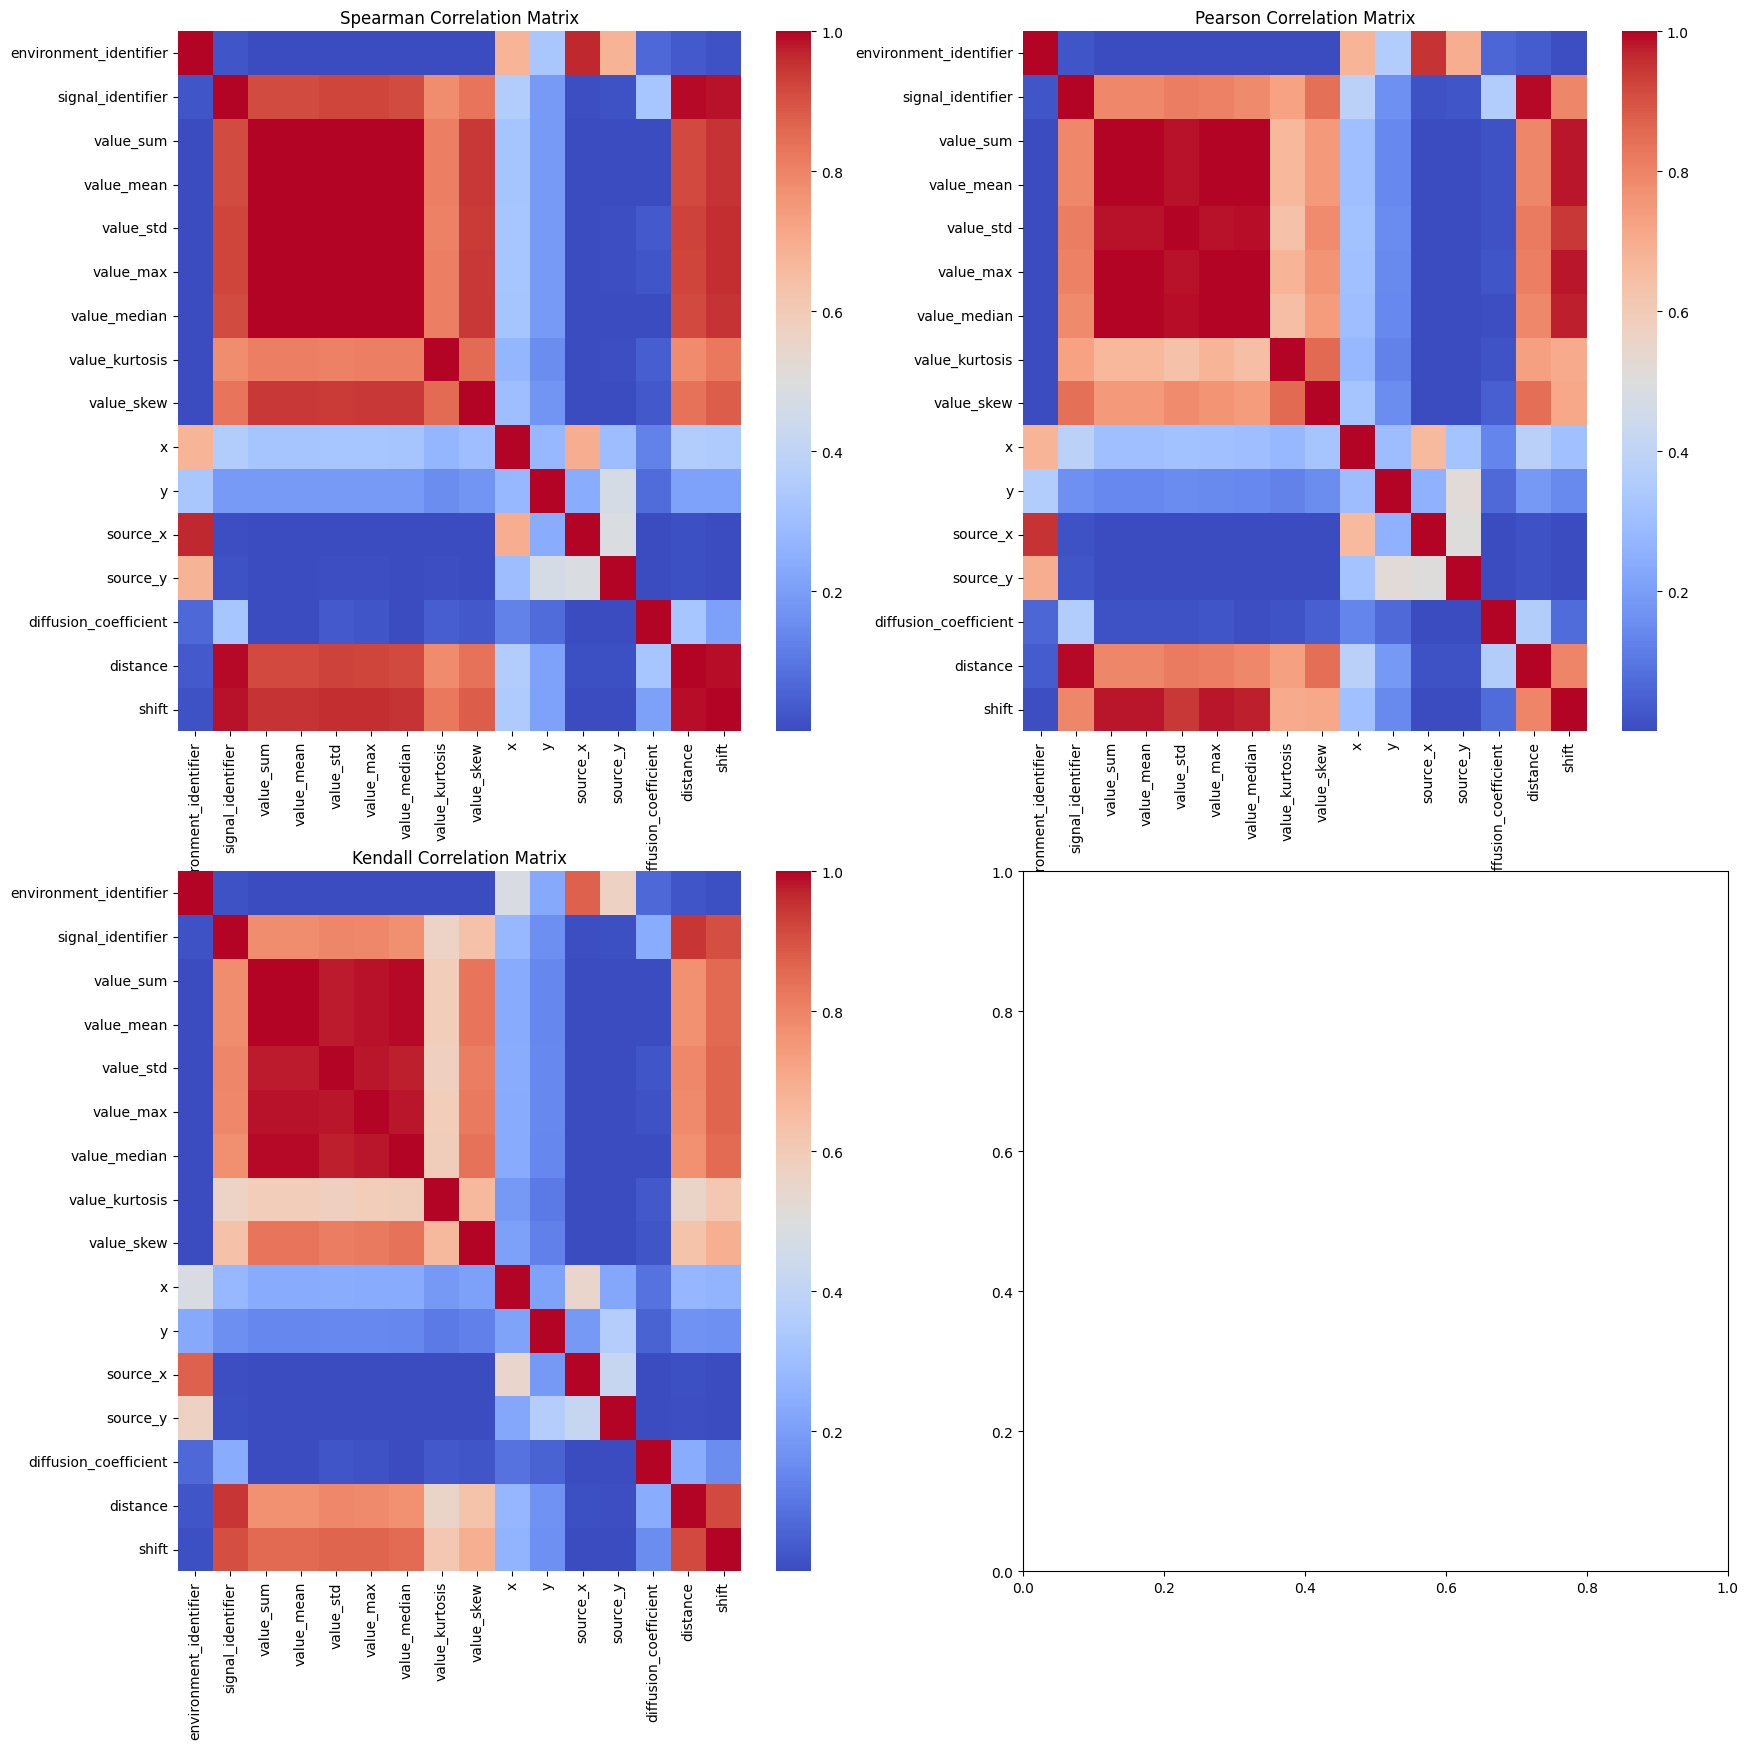

In [96]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20))

sns.heatmap(np.abs(data.corr(method="spearman")), cmap='coolwarm', ax=axes[0, 0])
axes[0, 0].set_title("Spearman Correlation Matrix")

sns.heatmap(np.abs(data.corr(method="pearson")), cmap='coolwarm', ax=axes[0, 1])
axes[0, 1].set_title("Pearson Correlation Matrix")

sns.heatmap(np.abs(data.corr(method="kendall")), cmap='coolwarm', ax=axes[1, 0])
axes[1, 0].set_title("Kendall Correlation Matrix")

We see that is seems there's at least a monotonic relationship between the `distances_to_source` variable and `relative_offsets`.

# 2. Dense model training

Let's train a model to predict the distance to the target based on the data.

1. Define the target variable and the features

In [97]:
x = data[["value_sum", "value_mean", "value_std", "value_max", "value_median", "value_kurtosis", "value_skew", "shift"]]
y = data[["distance"]].to_numpy()

2. Normalize the input data for better performance

In [98]:
scaler = StandardScaler()

x = scaler.fit_transform(x)

1. Prepare a k-fold cross-validation

In [99]:
fold = KFold(n_splits=5, shuffle=True, random_state=42)

1. Prepare the tensorflow keras model from the data

In [100]:
def create_dense_model():
    # Configure tensorflow to use 20 threads
    os.environ["OMP_NUM_THREADS"] = "20"

    tf.config.threading.set_inter_op_parallelism_threads(20) 
    tf.config.threading.set_intra_op_parallelism_threads(20)
    tf.config.set_soft_device_placement(True)

    # Create a model
    model = Sequential([
        Dense(256, activation='relu', input_shape=(8,)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

model = create_dense_model()

/home/alix_anneraud/.python_environment/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6. Set the early stopping callback to avoid overfitting. If the model does not improve after 10 epochs, the training will stop and the best model will be saved.

In [101]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

5. Train the model

In [102]:
def train_dense_model(model, x, y, fold, early_stopping, epochs=200):
    n_splits = fold.get_n_splits()

    for i, (train_index, test_index) in enumerate(fold.split(x)):
        print(f"Training with fold {i + 1} in {n_splits} (train size: {len(train_index)}, test size: {len(test_index)})")

        x_train = x[train_index]
        x_test = x[test_index]
        y_train = y[train_index]
        y_test = y[test_index]

        batch_size = (x_train.nbytes + y_train.nbytes) // 2

        model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), callbacks=[early_stopping])

train_dense_model(model, x, y, fold, early_stopping)

Training with fold 1 in 5 (train size: 2667, test size: 667)
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step - loss: 15.4645 - val_loss: 15.1544
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 14.2565 - val_loss: 14.1336
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 13.2710 - val_loss: 13.2099
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 12.3851 - val_loss: 12.3536
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 11.5642 - val_loss: 11.5346
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 10.7793 - val_loss: 10.7080
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 9.9897 - val_loss: 9.8830
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 9.2009 - val_loss: 9.0454
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 8.4032 - val_loss: 8.1679
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 7.5702 - val_loss: 7.2537
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 6.7041 - val_loss: 6.3205


6. Save the model and the scaler to disk

In [103]:
# Save the model to disk
model.save("model.keras")
# Save the scaler to disk
dump(scaler, open("scaler.pkl", "wb"))

Let's plot the error of the model depending on the distance to the target and the diffusion coefficient.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


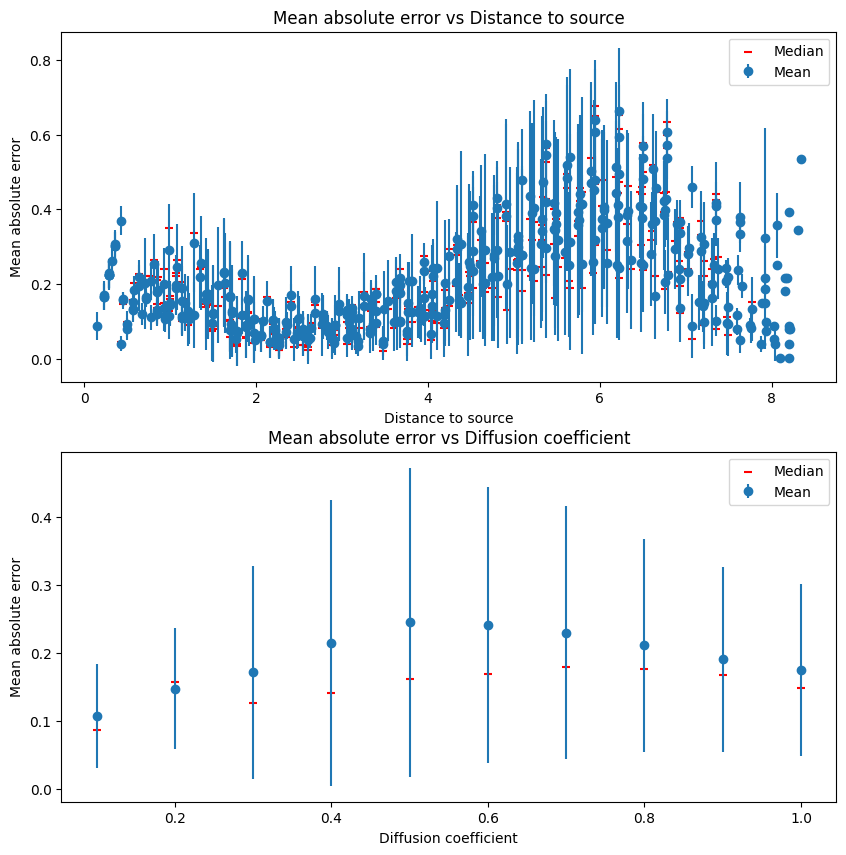

In [109]:
steps = 1

predictions = model.predict(x[::steps], batch_size=16777216)

error = np.abs(predictions.flatten() - y[::steps].flatten())

prediction_data = pd.DataFrame({
    "distance": data["distance"][::steps],
    "predictions": predictions.flatten(),
    "diffusion_coefficient": data["diffusion_coefficient"][::steps],
    "error": error
})


grouped = prediction_data.groupby("distance")

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

mean = grouped.mean()
std = grouped.std()
median = grouped.median()

axes[0].errorbar(mean.index, mean["error"], yerr=std["error"], fmt='o', label="Mean")
axes[0].scatter(median.index, median["error"], label="Median", color="red", marker="_")
axes[0].set_xlabel("Distance to source")
axes[0].set_ylabel("Mean absolute error")
axes[0].set_title("Mean absolute error vs Distance to source")
axes[0].legend()

grouped = prediction_data.groupby("diffusion_coefficient")

mean = grouped.mean()
std = grouped.std()
median = grouped.median()

axes[1].errorbar(mean.index, mean["error"], yerr=std["error"], fmt='o', label="Mean")
axes[1].scatter(median.index, median["error"], label="Median", color="red", marker="_")
axes[1].set_xlabel("Diffusion coefficient")
axes[1].set_ylabel("Mean absolute error")
axes[1].set_title("Mean absolute error vs Diffusion coefficient")
axes[1].legend()